In [1]:
import keras
import tensorflow as tf

# Memory Pre-configuration
config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(
        per_process_gpu_memory_fraction=0.9,
        allow_growth = True
    )
    # device_count = {'GPU': 1}
)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

tf.compat.v1.disable_eager_execution()

이번 예제는 개별적인 레이블 대신 **연속적인 값**을 예측하는 **회귀 (Regression)** 문제입니다.

### 보스턴 주택 가격 데이터셋

1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율 등 각종 데이터가 주어졌을때의 주택 가격의 중간 값을 예측하는 문제입니다. 이 예제는 [IMDB 이진 분류 문제](https://michaelhur.github.io/IMDB-Binary-Classification/)와 [로이터 뉴스 다중 분류 문제](https://michaelhur.github.io/Reuters-News-Classification/)와는 다르게 데이트 포인트가 적고 각 특성의 스케일이 서로 다릅니다. 어떤 특성은 0과 1 사이의 비율을 나타내고, 어떤 특성은 1과 12 사이의 값, 어떤 값은 1과 100 사이의 값을 가집니다.

##### 데이터셋 로드

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

```python
>>> train_data.shape
(404, 13)
```

```python
>>> test_data.shape
(102, 13)
```

[IMDB 이진 분류 문제](https://michaelhur.github.io/IMDB-Binary-Classification/)와 [로이터 뉴스 다중 분류 문제](https://michaelhur.github.io/Reuters-News-Classification/)와는 다르게 404개의 훈련 샘플과 102개의 테스트 샘플만이 존재하고 각각 13개의 특성이 존재합니다.

타깃은 주택의 중간 가격 (median)으로 천 달러 단위입니다.
```python
[15.2, 42.3, 50., ..., 19.4, 29.1]
```

### 데이터 준비

상이한 스케일을 가진 값을 신경망에 주입하면 문제가 생깁니다. 특성의 스케일이 다르면 Global Minimum을 찾아가는 SGD의 경로가 스케일이 큰 특성에 영향을 많이 받습니다. 즉 학습을 더 어렵게 만듭니다. 이런 데이터를 다룰때 대표적인 방법은 특성별로 *정규화 (standardize)*하는 것입니다.
* 각 특성에 대해서 특성의 평균을 빼고 표준 편차로 나누어줌 
* 특성의 평균이 0에 맞추어지고 표준 편차가 1이 됨

##### 데이터 정규화 하기

In [3]:
mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std

test_data -= mean
test_data /= std

테스트 데이터를 표준화할때 사용한 값 역시 훈련 데이터에서 계산한 값.

### 모델 구성

샘플 개수가 적기 때문에 64개의 유닛을 가진 2개의 은닉 층으로 작은 네트워크를 구성하여 사용하겠습니다.

In [4]:
from keras import layers, models

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    
    return model

이 네트워크의 마지막 층 `layer.Dense(1)`은 활성화 함수가 없습니다. 활성화 함수를 적용하면 출력 값의 범위를 *제한*하게 됩니다. 예를 들면, 마지막 층에 `sigmoid` 함수를 적용하면 네트워크의 최종 출력은 0과 1사이의 값을 예측하도록 학습됩니다.

이 모델은 *평균 제곱 오차 (mean squared error)*을 손실 함수로 사용합니다. 예측과 타깃 사이 거리의 제곱을 계산합니다. 훈련하는 동안에는 **평균 절대 오차 (mean absolute error)**를 측정합니다. 이는 예측과 타깃 사이의 절대값입니다.

### K-겹 검증을 사용한 훈련 검증 (K-fold cross validation)

데이터 포인트가 많지 않기 때문에 검증 세트도 매우 작아집니다. 결국 검증 세트와 훈련 세트가 어떤 데이터 포인트가 선택되었는지에 따라 검증 점수가 달라집니다. 이런 상황에서 가장 좋은 방법은 *K-겹 교차 검증 (K-fold cross-validation)*을 사용하는 것입니다.
* 데이터를 K개의 분할 (fold)로 나누고, K개의 모델을 만들어 각각 K-1개의 분할에서 훈련하고 나머지 분할에서 평가하는 방법
* 모델의 검증 점수는 K개의 검증 점수 평균

![](../images/3-7-Kfold.png)

##### K-fold cross-validation

In [5]:
import numpy as np

k = 4

num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print("처리중인 폴드 #:", i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]], axis = 0)
    
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                           train_targets[(i + 1) * num_val_samples:]], axis = 0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 1, verbose = 0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)

처리중인 폴드 #: 0


/home/jhhur/anaconda3/envs/TIL2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


처리중인 폴드 #: 1
처리중인 폴드 #: 2
처리중인 폴드 #: 3


```python
>>> all_scores
[3.1349971294403076, 2.878347158432007, 3.1985702514648438, 3.552551031112671]

>>> np.mean(all_scores)
3.1911163926124573
```

검증 세트가 다르므로 검증 점수가 2.8에서 3.5까지 변화가 큽니다. 평균값 (3.19)가 각각의 점수보다 훨씬 신뢰할 만합니다. 이것이 K-겹 교차 검증의 핵심입니다.

이번에는 500 에포크동안 훈련 시켜보도록 하겠습니다.

In [6]:
k = 4

num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print("처리중인 폴드 #:", i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]], axis = 0)
    
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                           train_targets[(i + 1) * num_val_samples:]], axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data = (val_data, val_targets),
                        epochs = num_epochs, batch_size = 1, verbose = 0)
    
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 #: 0
처리중인 폴드 #: 1
처리중인 폴드 #: 2
처리중인 폴드 #: 3


모든 폴드에 대해 에포크의 MAE 점수 평균을 계산합니다

In [7]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

그래프로 나타내면 다음과 같습니다.

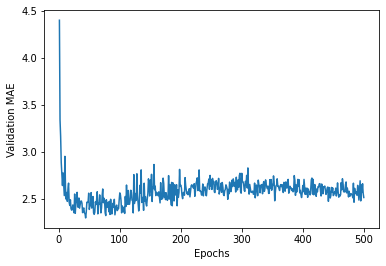

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

그래프의 범위가 크고 변동이 심하기 때문에 보기가 힘듭니다. 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 *지수 이동 평균 exponential moving average*로 대체합니다.

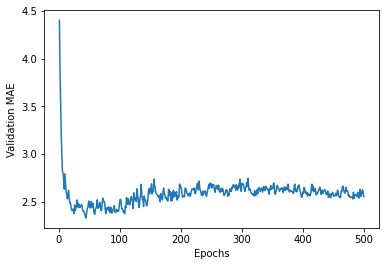

In [9]:
def smooth_curve(points, factor = 0.5):
    smoothed_points = []
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
            
        else:
            smoothed_points.append(point)
            
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history)

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

검증 MAE가 약 80번째 에포크 이후에 줄어드는 것이 멈추었습니다.

##### 최종 모델 훈련

In [10]:
model = build_model()
model.fit(train_data, train_targets,
          epochs = 80, batch_size = 16, verbose = 0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

/home/jhhur/anaconda3/envs/TIL2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


```python
>>> test_mse_score
10.024432182312012
```